<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/Soma_Axial_Currents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
is_colab = 'google.colab' in str(get_ipython())

In [2]:
if is_colab:
    !git clone https://github.com/davidfague/Neural-Modeling.git
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 904, done.
remote: Counting objects: 100% (461/461), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 904 (delta 307), reused 395 (delta 264), pack-reused 443
Receiving objects: 100% (904/904), 4.93 MiB | 12.37 MiB/s, done.
Resolving deltas: 100% (578/578), done.
Mounted at /content/drive
/content/drive/MyDrive


In [3]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits import mplot3d
import pdb #python debugger

In [4]:
output_folder = 'L5PCtemplate[0]_45e-1Hz_196nseg_2000ms_108nbranch_29068NCs_29068nsyn'

v = h5py.File('./{}/Vm_report.h5'.format(output_folder),'r') #read segment voltage traces

gNaTa = h5py.File('./{}/gNaTa_T_data_report.h5'.format(output_folder),'r') #read segment voltage traces
iampa = h5py.File('./{}/i_AMPA_report.h5'.format(output_folder),'r') #read segment voltage traces
inmda = h5py.File('./{}/i_NMDA_report.h5'.format(output_folder),'r') #read segment voltage traces
igaba = h5py.File('./{}/i_GABA_report.h5'.format(output_folder),'r') #read segment voltage traces
icah = h5py.File('./{}/icah_data_report.h5'.format(output_folder),'r') #read segment voltage traces
ical = h5py.File('./{}/ical_data_report.h5'.format(output_folder),'r') #read segment voltage traces
ih = h5py.File('./{}/ih_data_report.h5'.format(output_folder),'r') #read segment voltage traces
ina = h5py.File('./{}/ina_data_report.h5'.format(output_folder),'r') #read segment voltage traces


spikes = h5py.File('./{}/spikes_report.h5'.format(output_folder),'r') #read segment voltage traces

segs = pd.read_csv('./{}/seg_info.csv'.format(output_folder)) # read segment values

In [5]:
v=v['report']['biophysical']['data']
gNaTa=gNaTa['report']['biophysical']['data']
iampa=iampa['report']['biophysical']['data']
inmda=inmda['report']['biophysical']['data']
igaba=igaba['report']['biophysical']['data']
icah=icah['report']['biophysical']['data']
ical=ical['report']['biophysical']['data']
ih=ih['report']['biophysical']['data']
ina=ina['report']['biophysical']['data']
spikes=spikes['report']['biophysical']['data']

In [6]:
# print(segs.columns)

Probe class for making a segment's attributes accesible.

In [7]:
#Get Columns
segs['sec index'] = segs['sec index'].astype(int)
segs['x'] = segs['x'].astype(float)

#get simulation time
v_len=len(v[:,0])
tstop=2000.1 #simulation stop
dt=0.1 #timestep
t=np.arange(0,tstop,dt) #time array
print(v_len) #should be equivalnt to (tstop=1000ms)/(dt=0.1ms)=10000
print(len(t))
if len(t)!=v_len:
  print('Update Time array')

20001
20001


In [8]:
!git clone https://github.com/davidfague/Neural-Modeling.git

fatal: destination path 'Neural-Modeling' already exists and is not an empty directory.


In [9]:
%cd Neural-Modeling/

/content/drive/MyDrive/Neural-Modeling


In [10]:
from Modules.segment import Segment

In [11]:
segments=[]

# Use Segment() class to store segment info and recorded data
for i in range(len(segs)):
    # assuming v, gNaTa etc. are pre-defined arrays or lists
    seg_data = {
        'v': v[:,i],
        'gNaTa': gNaTa[:,i],
        'iampa': iampa[:,i],
        'inmda': inmda[:,i],
        'icah': icah[:,i],
        'ical': ical[:,i],
        'ih': ih[:,i],
        'ina': ina[:,i],
        'igaba': igaba[:,i]
    }
    newprobe = Segment(seg_info = segs.iloc[i], seg_data = seg_data)
    segments.append(newprobe)

In [12]:
# dir(segments[0])

Determine which segments are next to each other.

In [13]:
# getting adjacent segments using parent segment IDs
# getting children segments
for i in range(len(segs['pseg index'])):  # iterate through segment index
    psegid = segs['pseg index'][i]
    if not np.isnan(psegid):
        psegid = int(psegid)
        for seg_index in segs['seg index']:  # check segIDs
            if psegid == seg_index:  # find parent seg from parent seg id
                segments[seg_index].adj_segs.append(segments[i])  # add child seg to this seg's adj_segs list
                segments[seg_index].child_segs.append(segments[i])  # add child seg to this seg's child_segs list

# getting parent segment
for i in range(len(segs)):
    psegid = segs['pseg index'][i]
    if not np.isnan(psegid):
        psegid = int(psegid)
        segments[i].adj_segs.append(segments[psegid])  # add parent seg probe to adj probes
        segments[i].parent_segs.append(segments[psegid])  # add parent seg probe to parent probes


Compute axial currents from each segment toward its adjacent segments.

In [14]:
#compute axial currents between all segments
for seg in segments:
  for adj_seg in seg.adj_segs:
    axc = (seg.v - adj_seg.v) / (seg.seg_half_seg_Ra + adj_seg.seg_half_seg_Ra) #compute axial current using (v_in-v_out)/(halfsegRa+halfsegRa)
    seg.axial_currents.append(axc)
    if adj_seg in seg.parent_segs:
      seg.parent_axial_currents.append(axc)
    elif adj_seg in seg.child_segs:
      seg.child_axial_currents.append(axc)

Find soma segments

In [15]:
#Find soma segments
soma_segs = []
for seg in segments:
  if seg.Type == 'soma':
    soma_segs.append(seg)
if len(soma_segs) != 1:
  raise(ValueError("There should be only one soma segment."))

Plot segments adjacent to soma

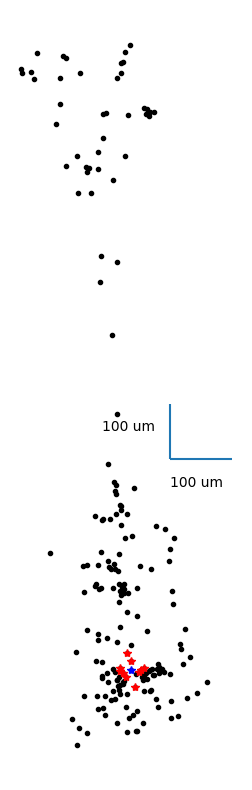

In [16]:
plt.figure(figsize=(3,10))
ax = plt.plot(segs['p0.5 x3d'], segs['p0.5 y3d'],'.',color='black',markersize=6)
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
plt.box(False)

# plot segments that are adjacent to soma segments
for soma_seg in soma_segs:
  for adj_seg in soma_seg.adj_segs:
    plt.plot(adj_seg.p0_5_x3d,
          adj_seg.p0_5_y3d,
          '*',color='red')

# plot soma segment
for seg in soma_segs:
  plt.plot(seg.p0_5_x3d,
         seg.p0_5_y3d,
         '*',color='blue')

Plot Axial Currents

In [17]:
def plot_axial_currents(segment):
  title='Axial Current from ['+segment.name+'] to adjacent segments'
  plt.figure(figsize=(12.8,4.8))
  for i,adj_seg in enumerate(segment.adj_segs):
    plt.plot(t, segment.axial_currents[i], label = adj_seg.name, color = adj_seg.color)
  plt.ylabel('nA')
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.legend()
  plt.show()

def plot_axial_currents_and_voltages(segment):
  title='Axial Current from ['+segment.name+'] to adjacent segments'
  plt.figure(figsize=(12.8,4.8))
  for i,adj_seg in enumerate(segment.adj_segs):
    plt.plot(t, segment.axial_currents[i], label = adj_seg.name, color = adj_seg.color)
  plt.ylabel('nA')
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.legend()
  plt.show()

  title='Vm from ['+segment.name+'] and adjacent segments'
  plt.figure(figsize=(12.8,4.8))
  plt.plot(t, segment.v, color = segment.color, label = segment.name)
  for i,adj_seg in enumerate(segment.adj_segs):
    plt.plot(t, adj_seg.v, label = adj_seg.name, color = adj_seg.color)
  plt.ylabel('mV')
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.legend()
  plt.show()

def plot_currents_and_voltages(segment):
  title='Axial Current from ['+segment.name+'] to adjacent segments'
  plt.figure(figsize=(12.8,4.8))
  for i,adj_seg in enumerate(segment.adj_segs):
    plt.plot(t, segment.axial_currents[i], label = adj_seg.name, color = adj_seg.color)
  plt.ylabel('nA')
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.legend()
  plt.show()

  title='Vm from ['+segment.name+'] and adjacent segments'
  plt.figure(figsize=(12.8,4.8))
  plt.plot(t, segment.v, color = segment.color, label = segment.name)
  for i,adj_seg in enumerate(segment.adj_segs):
    plt.plot(t, adj_seg.v, label = adj_seg.name, color = adj_seg.color)
  plt.ylabel('mV')
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.legend()
  plt.show()

  title='Currents from ['+segment.name+']'
  plt.figure(figsize=(12.8,4.8))
  currents=['iampa', 'icah', 'ical', 'ih', 'ina', 'inmda', 'igaba']
  for current in currents:
    plt.plot(t, getattr(segment, current), label = current)
  plt.ylabel('mV')
  plt.title(title)
  plt.xlabel('time (ms)')
  plt.legend()
  plt.show()

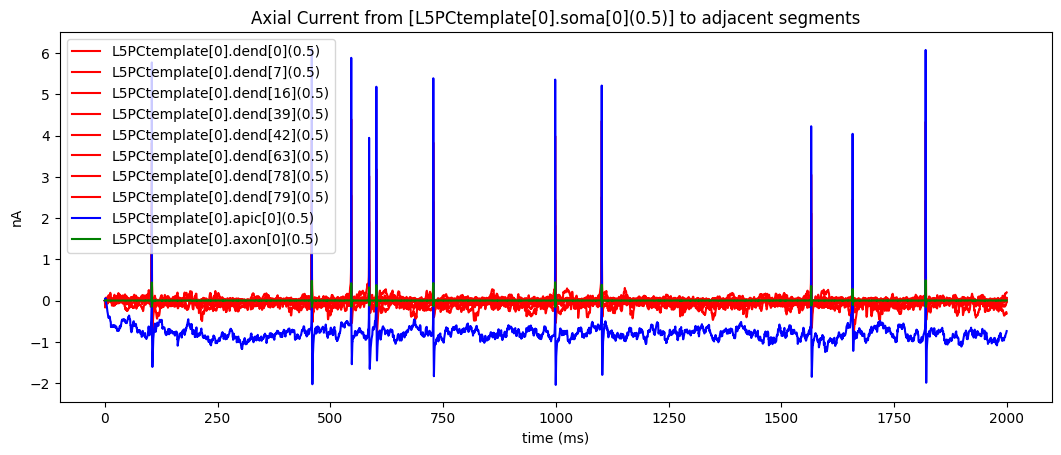

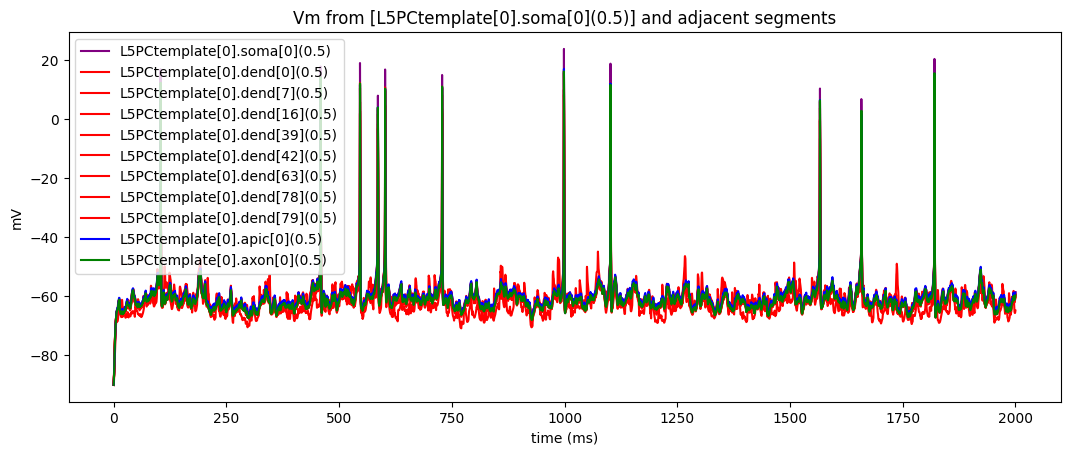

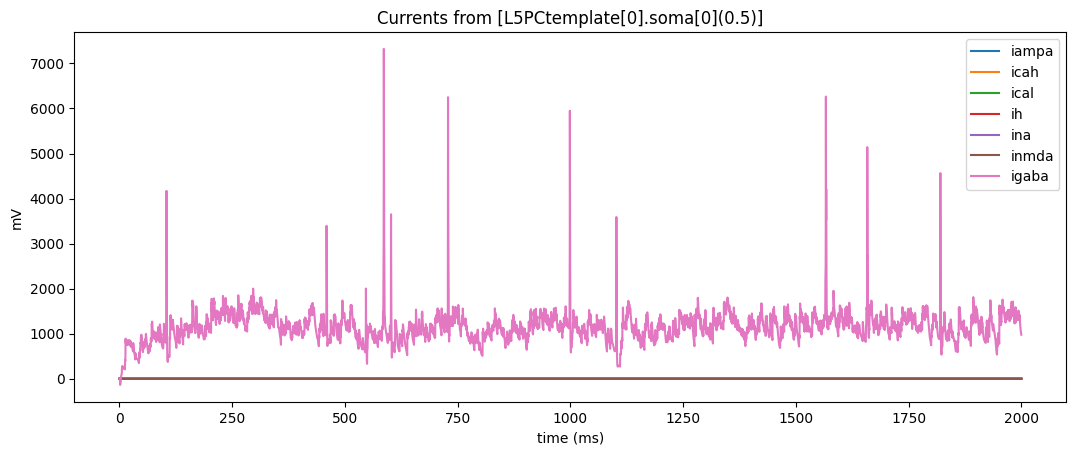

In [18]:
for seg in soma_segs:
  plot_currents_and_voltages(seg)